In [2]:
from Lib.LoadDIODE import *
from Lib.VisualizationDIODE import *
from Lib.ModelsDIODE import *
import json

path='../Experiment/exp24'
with open(path+'/config.json', 'r') as file:
    # Leggi il contenuto del file JSON
    config = json.load(file)

train_scenes = config["train_scenes"]
val_scenes = config["val_scenes"]
test_scenes = config["test_scenes"]
enable_aug_train = config["enable_aug_train"]
enable_aug_val = config["enable_aug_val"]
enable_aug_test = config["enable_aug_test"]
clamp = config["clamp"]
percentuale = config["percentuale"]
batch_size = config["batch_size"]
shuffle = config["shuffle"]
show_clip = config["show_clip"]
en_clip = config["en_clip"]
enable_BatchNorm2d_alllayer = config["enable_BatchNorm2d_alllayer"]
enable_Dropout_alllayer = config["enable_Dropout_alllayer"]
decrease_dropout = config["decrease_dropout"]
value_dropout = config["value_dropout"]

size = tuple(config["size"])
path_dataset="../Datasets/DIODE_FULL - Copia (2)"
path_dst = '../Csv/'
csv_path="../Csv/path_images.csv"
csv_path_aug="../Csv/path_images_aug.csv"
csv_path_not_aug="../Csv/path_images_not_aug.csv"

csv_train_path=path_dst+"path_train.csv"
csv_val_path=path_dst+"path_val.csv"
csv_test_path=path_dst+"path_test.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

create_df_ipcv_diode(path_dataset,path_dst=path_dst)   
train_val_test_split(csv_path_aug, csv_path_not_aug, path_dst=path_dst,enable_aug_train=enable_aug_train, enable_aug_val=enable_aug_val, enable_aug_test=enable_aug_test)
# faccio clipping sulla depth_map 
if en_clip:
    train_set =CustomDataset(csv_train_path, perc_dataset=percentuale, transform=rgb_transformations_base(size,device), target_transform=depth_map_transformations_clip(size,device))
    val_set = CustomDataset(csv_val_path, perc_dataset=percentuale, transform=rgb_transformations_base(size,device), target_transform=depth_map_transformations_clip(size,device))
else:
    train_set = CustomDataset(csv_train_path, perc_dataset=percentuale, transform=rgb_transformations_base(size,device), target_transform=depth_map_transformations_no_clip(size,device))
    val_set = CustomDataset(csv_val_path, perc_dataset=percentuale, transform=rgb_transformations_base(size,device), target_transform=depth_map_transformations_no_clip(size,device))
test_set = CustomDataset(csv_test_path, perc_dataset=1, transform=rgb_transformations_test(device), target_transform=depth_map_transformations_test(device))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=shuffle)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=shuffle)


cuda


In [6]:
dict_model={}
model_d =Densenet121_Decoder(enable_BatchNorm2d_alllayer=config['enable_BatchNorm2d_alllayer'],
                            enable_Dropout_alllayer=config['enable_Dropout_alllayer'],
                            decrease_dropout=config['decrease_dropout'],value_dropout=config['value_dropout'])
model_d.load_state_dict(torch.load(path+'/best_model.pt'))
if torch.cuda.is_available():
    model_d.cuda()
dict_model['Dense-ED']=model_d

# #SKIP
# model_sk = ED_SkippConnection()
# model_sk.load_state_dict(torch.load('/home/giuliano/Downloads/best_model.pt'))
# if torch.cuda.is_available():
#     model_sk.cuda()


# #SCRATCH
# model_s =Encoder_Decoder()
# model_s.load_state_dict(torch.load('/media/giuliano/SSD_GB/Programming/University/IPCV (Diode)/Experiment/exp37/best_model.pt'))
# if torch.cuda.is_available():
#     model_s.cuda()

C:\Users\digig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\digig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
def clamp(img_rgbd_np):
    lower_percentile = np.percentile(img_rgbd_np, 5)
    upper_percentile = np.percentile(img_rgbd_np, 95)
    img_rgbd_np[img_rgbd_np < lower_percentile] = lower_percentile
    img_rgbd_np[img_rgbd_np > upper_percentile] = upper_percentile
    return img_rgbd_np

# Prende i pesi salvati
def print_dataset_pred3(dic_model,loader, rows=6, offset=0, model_path='/best_model.pt', save_path='',name=''):

    # Create a figure and axes with 6 rows and 3 columns
    fig, axes = plt.subplots(rows, (2+len(dic_model)))
    count=0
    # Iterate over the batch of the loader
    for batch, data in enumerate(loader):
        img_rgb, img_rgbd = data

        # Convert tensors to NumPy arrays
        img_rgb_np = img_rgb[0].permute(1, 2, 0).cpu().numpy()
        img_rgbd_np = img_rgbd[0].permute(1, 2, 0).cpu().numpy()

        # Display images in the subplot
        axes[count // 3, count % (2+len(dic_model))].imshow(img_rgb_np)
        axes[count // 3, count % (2+len(dic_model))].axis('off')
        axes[count // 3, count % (2+len(dic_model))].set_title("RGB Image")

        print(img_rgbd_np.max())
        img_rgbd_np=clamp(img_rgbd_np)
        
        axes[count // 3, count % (2+len(dic_model)) + 1].imshow(img_rgbd_np, cmap='jet')
        axes[count // 3, count % (2+len(dic_model)) + 1].axis('off')
        axes[count // 3, count % (2+len(dic_model)) + 1].set_title("RGBD Image")

        cnt=2
        for titolo, model in dic_model.items():
            model.eval()
            with torch.inference_mode():
                pred = model(img_rgb)
            result = pred[0].permute(1, 2, 0).cpu().detach().numpy()
            result=clamp(result)
            axes[count // 3, count % (2+len(dic_model)) + cnt].imshow(result, cmap='jet')
            axes[count // 3, count % (2+len(dic_model)) + cnt].axis('off')
            axes[count // 3, count % (2+len(dic_model)) + cnt].set_title(titolo)
            cnt+=1

        count += 3
        if count >= rows * 3:
            break

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Save the plot if save_path is provided
    if save_path != '':
        os.makedirs(save_path, exist_ok=True)
        save_file_path = os.path.join(save_path, str(name)+str(offset)+".png")
        plt.savefig(save_file_path)
        plt.close()
    else:
        # Display the plot
        plt.show()

7.1395354
6.823827
245.03477


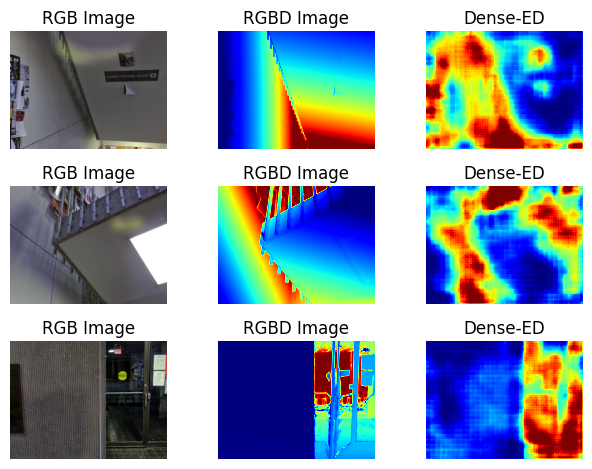

In [10]:
print_dataset_pred3(dict_model,test_loader, rows=3, offset=0, save_path='',name='')